In [2]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

data = pd.read_csv('master.csv')


#Renaming the columns names for convinience

data.columns = ['country', 'year', 'gender', 'age_group', 'suicide_count', 'population', 'suicides/100k', 'country-year', 'HDI for year',
                'gdp_for_year', 'gdp_per_capita', 'generation']

data = data.drop(['HDI for year', 'country-year'], axis = 1)
data = data.dropna()

#################################################################################
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Encode 'gender'
le_sex = LabelEncoder()
data['gender_enc'] = le_sex.fit_transform(data['gender'])

# Encode 'age' as ordinal
age_order = ["5-14 years", "15-24 years", "25-34 years", 
             "35-54 years", "55-74 years", "75+ years"]
ord_age = OrdinalEncoder(categories=[age_order])
data['age_enc'] = ord_age.fit_transform(data[['age_group']]).astype(int)

# One-hot encode 'generation'
data = pd.get_dummies(data, columns=['generation'], prefix='gen')
gen_cols = [col for col in data.columns if col.startswith('gen_')]
data[gen_cols] = data[gen_cols].astype(int)

# Converting the column 'gdp_for_year' to float from object
data['gdp_for_year'] = data['gdp_for_year'].str.replace(',','').astype(float)

data = data.drop(['gender', 'age_group'], axis=1)

##################################################################################

from sklearn.model_selection import train_test_split, KFold
import category_encoders as ce

# Define features and target
y = data['suicides/100k']
X = data.drop(columns=['suicides/100k', 'suicide_count', 'population'])

#split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# ---------------------- Target Encoding with K-Fold CV ----------------------

# (a) Create an empty Series to collect fold-wise encodings
country_te_train = pd.Series(index=X_train.index, dtype=float)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for tr_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr = y_train.iloc[tr_idx]
    
    te_fold = ce.TargetEncoder(cols=['country'])
    te_fold.fit(X_tr[['country']], y_tr)
    
    country_te_train.iloc[val_idx] = (
        te_fold.transform(X_val[['country']])['country']
    ).values

# (b) Fit a final encoder on *all* training data, for the test set
final_te = ce.TargetEncoder(cols=['country'])
final_te.fit(X_train[['country']], y_train)
country_te_test = final_te.transform(X_test[['country']])['country'].values

# (c) Drop the raw 'country' feature and insert the encoded versions
X_train_enc = X_train.drop(columns=['country']).copy()
X_train_enc['country_te'] = country_te_train

X_test_enc = X_test.drop(columns=['country']).copy()
X_test_enc['country_te'] = country_te_test

############################################################################
# --- Scale numeric features with RobustScaler -------------------------------
from sklearn.preprocessing import RobustScaler

# Identify numeric cols (all except the one‐hot gen_ columns and encodings are numeric)
num_cols = [
    'gdp_for_year', 'gdp_per_capita','country_te'
]

scaler = RobustScaler()
X_train_enc[num_cols] = scaler.fit_transform(X_train_enc[num_cols])
X_test_enc[num_cols]  = scaler.transform(X_test_enc[num_cols])


# --- Now X_train_enc, X_test_enc, y_train, y_test are ready for modeling! --------

print("Train shape:", X_train_enc.shape)
print("Test shape: ", X_test_enc.shape)
#############################################################################


Train shape: (24444, 12)
Test shape:  (6112, 12)


In [3]:
import os
import pickle
import random
import time
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn_genetic import GAFeatureSelectionCV

# Reproducibility
random.seed(42)
np.random.seed(42)

# === Load or initialize checkpoint ===
checkpoint_path = "ga_feature_selection_checkpoint.pkl"
if os.path.exists(checkpoint_path):
    with open(checkpoint_path, "rb") as f:
        saved = pickle.load(f)
    completed_models = saved['completed']
    cv_results = saved['cv_results']
    test_results = saved['test_results']
    print(f"Checkpoint loaded. Completed models: {list(completed_models)}")
else:
    completed_models = set()
    cv_results, test_results = [], []

# === Data ===
X_all = X_train_enc.copy()
y_all = y_train.copy()
kf_outer = KFold(n_splits=10, shuffle=True, random_state=42)

# === Define models ===
models = {
    'Poly SVM': Pipeline([
        ('model', SVR(kernel='poly', degree=3, C=1, gamma='scale'))
    ]),
    'Linear SVM': Pipeline([
        ('model', LinearSVR(C=10, epsilon=1, max_iter=10000, random_state=42))
    ]),
    'RBF SVM': Pipeline([
        ('model', SVR(kernel='rbf', C=100, gamma=0.01))
    ]),
    'KNN': KNeighborsRegressor(n_neighbors=11, weights='distance', p=1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 100), learning_rate_init=0.01, alpha=0.001, max_iter=500, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=0.1, random_state=42)
}

# === Run loop ===
for name, model in models.items():
    if name in completed_models:
        print(f"\n>>> Skipping {name}, already completed.")
        continue

    print(f"\n=== Starting GA feature selection for {name} ===")
    start_time = time.time()

    if name == 'Poly SVM':
        selector = GAFeatureSelectionCV(
            estimator=clone(model),
            cv=5,  # Lighter for faster run
            scoring="neg_root_mean_squared_error",
            population_size=6,
            generations=8,
            n_jobs=-1,
            verbose=2,
            keep_top_k=1,
            elitism=True,
            crossover_probability=0.8,
            mutation_probability=0.2,
            tournament_size=3
        )
    else:
        selector = GAFeatureSelectionCV(
            estimator=clone(model),
            cv=10,
            scoring="neg_root_mean_squared_error",
            population_size=10,
            generations=15,
            n_jobs=-1,
            verbose=2,
            keep_top_k=2,
            elitism=True,
            crossover_probability=0.8,
            mutation_probability=0.2,
            tournament_size=3
        )

    print("-> Fitting selector... (this may take a while)")
    try:
        selector.fit(X_all, y_all)
    except Exception as e:
        print(f"!!! Error fitting GA for {name}: {e}")
        continue

    print(f"-> GA complete for {name}")
    selected = X_all.columns[selector.support_]
    print(f"Selected {len(selected)} features for {name}: {list(selected)}")

    # === Nested CV ===
    maes, mses, rmses = [], [], []
    print(f"-> Running nested CV for {name}")
    for i, (train_idx, val_idx) in enumerate(kf_outer.split(X_all), 1):
        X_tr, X_val = X_all.iloc[train_idx][selected], X_all.iloc[val_idx][selected]
        y_tr, y_val = y_all.iloc[train_idx], y_all.iloc[val_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        maes.append(mean_absolute_error(y_val, y_pred))
        mses.append(mean_squared_error(y_val, y_pred))
        rmses.append(np.sqrt(mses[-1]))
        print(f"  Fold {i}/10: RMSE = {rmses[-1]:.4f}")

    cv_results.append({'Model': name, 'MAE': np.mean(maes), 'MSE': np.mean(mses), 'RMSE': np.mean(rmses)})

    # === Test evaluation ===
    print(f"-> Evaluating on test set for {name}")
    X_test_sel = X_test_enc[selected]
    model.fit(X_all[selected], y_all)
    y_test_pred = model.predict(X_test_sel)
    test_results.append({
        'Model': name,
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
    })
    print(f"=== Finished {name}: Test RMSE = {test_results[-1]['Test RMSE']:.4f} ===")

    # Print model duration
    elapsed = time.time() - start_time
    print(f"--- {name} took {elapsed/60:.2f} minutes ---")

    # === Save checkpoint ===
    completed_models.add(name)
    with open(checkpoint_path, "wb") as f:
        pickle.dump({
            'completed': completed_models,
            'cv_results': cv_results,
            'test_results': test_results
        }, f)
    print(f"Checkpoint saved after {name}")

# === Final summary ===
print("\n=== All Models Completed ===")
df_cv = pd.DataFrame(cv_results)
df_test = pd.DataFrame(test_results)
print("\nCross-Validation Results:")
print(df_cv)
print("\nTest Set Results:")
print(df_test)


Checkpoint loaded. Completed models: ['RBF SVM', 'Linear SVM']

=== Starting GA feature selection for Poly SVM ===
-> Fitting selector... (this may take a while)
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	6     	-22.4278	0.876273   	-20.4685   	-22.831    
1  	12    	-22.1154	1.00209    	-20.4685   	-22.8263   
2  	12    	-20.8519	0.178692   	-20.4685   	-20.9561   
3  	12    	-20.7942	0.164272   	-20.4685   	-20.9561   
4  	12    	-20.5615	0.131539   	-20.4685   	-20.7475   
5  	12    	-20.4403	0.0629566  	-20.2996   	-20.4685   
6  	12    	-19.5723	1.61739    	-15.9612   	-20.4685   
7  	12    	-18.0445	2.19128    	-15.8006   	-20.2996   
8  	12    	-17.1805	1.95732    	-15.8006   	-20.2026   
-> GA complete for Poly SVM
Selected 8 features for Poly SVM: ['gdp_per_capita', 'gender_enc', 'gen_Boomers', 'gen_G.I. Generation', 'gen_Generation Z', 'gen_Millenials', 'gen_Silent', 'country_te']
-> Running nested CV for Poly SVM
  Fold 1/10: RMSE = 15.7643
  Fold 2/10: RMSE


=== GA Feature Selection - CV vs Test Comparison ===
                        MAE         MSE       RMSE  Test MAE    Test MSE  \
Model                                                                      
Linear SVM         8.641408  331.125294  18.130491  8.499781  380.290969   
RBF SVM            5.227384  154.613467  12.417167  5.213605  164.959204   
Poly SVM           6.779803  250.954242  15.740426  6.779234  298.296045   
KNN                4.024873   92.989733   9.595054  3.991234  102.928581   
Random Forest      2.927219   59.128026   7.617756  2.703835   49.180648   
Decision Tree      3.895912  115.975834  10.649821  3.347706   65.720277   
MLP                4.480395   93.732570   9.544535  5.172063  135.149657   
Linear Regression  9.559632  265.696099  16.272704  9.358659  274.625581   
Ridge Regression   9.572212  266.706707  16.303811  9.346206  274.068144   

                   Test RMSE  
Model                         
Linear SVM         19.501050  
RBF SVM         

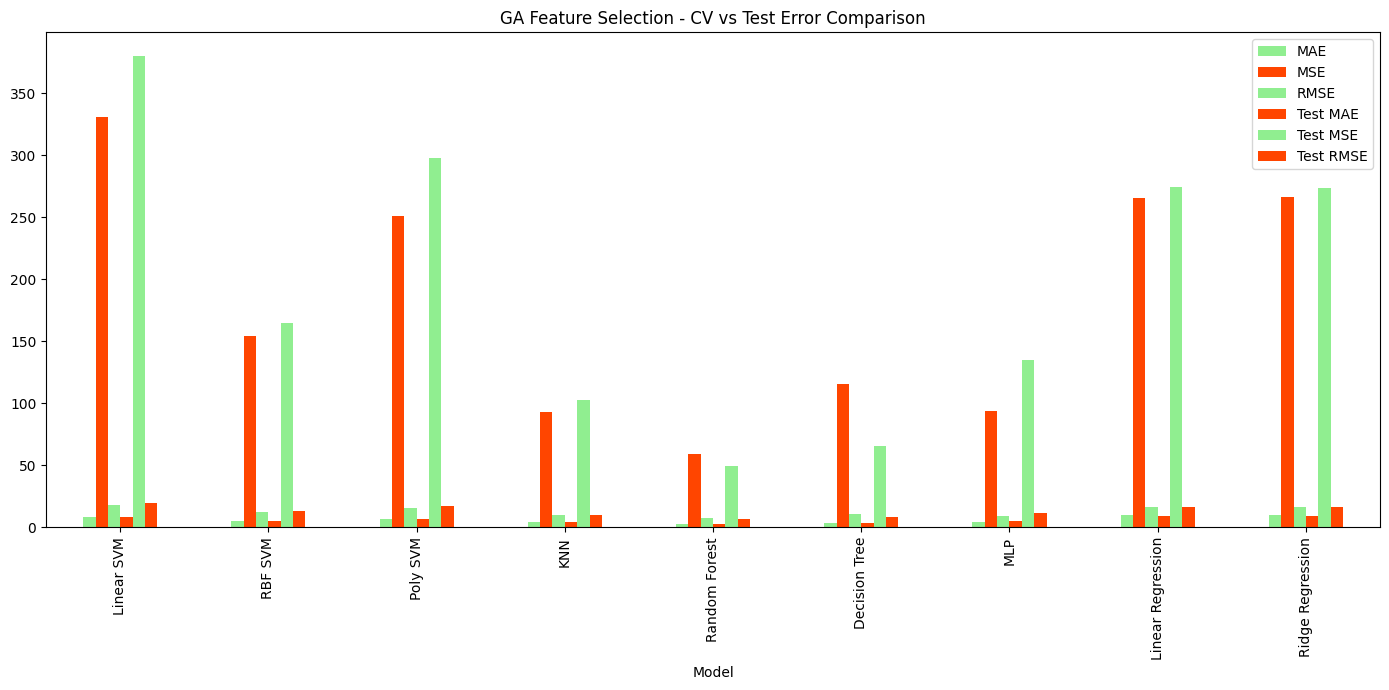

In [4]:
df_cv_ga = pd.DataFrame(df_cv).set_index('Model')
df_test_ga = pd.DataFrame(df_test).set_index('Model')
df_combined_ga = df_cv_ga.join(df_test_ga)

print("\n=== GA Feature Selection - CV vs Test Comparison ===")
print(df_combined_ga)

# Optional: visualize
df_combined_ga.plot(kind='bar', figsize=(14, 7), color=['lightgreen', 'orangered'])
plt.title('GA Feature Selection - CV vs Test Error Comparison')
plt.tight_layout()
plt.show()
